# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

Se toman los daily (en nuestro caso weekly) coeficientes de información, como el mejor indicador y no los totales.

## Imports & Settings

In [116]:
import warnings
warnings.filterwarnings('ignore')

In [117]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from scipy.stats import spearmanr, pearsonr
from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

sns.set_style('whitegrid')




DATA_STORE = 'data_neutralized/assets.h5'
DATA_ITEM = 'engineered_features_pca'
results_path = Path('results_neutralized_pca', 'us_stocks')

idx = pd.IndexSlice

In [118]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
rf_train_params = ['bagging_fraction', 'feature_fraction', 'min_data_in_leaf','max_depth']
catboost_train_params = ['max_depth', 'min_child_samples']

In [119]:

if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [120]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [121]:
# lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
# lgb_metrics.info()

In [122]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          464           1              702
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [123]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()


id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

# lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
# lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')

# lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
# lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


In [124]:
lgb_metrics.sort_values('ic', ascending=False)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
69,1,464,1,0.30,128.0,0.30,500.0,0.049253,25.0,0.045455,10.0,25,0.048464
374,1,464,1,0.01,128.0,0.60,250.0,0.037907,100.0,0.045455,500.0,200,0.048333
320,1,464,1,0.01,128.0,0.60,250.0,0.037907,100.0,0.045455,500.0,150,0.048067
11,1,464,1,0.30,32.0,0.30,250.0,0.044783,10.0,0.063636,10.0,10,0.047253
275,1,464,1,0.30,4.0,0.95,250.0,0.045288,200.0,0.072727,75.0,150,0.046444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,1,464,1,0.01,128.0,0.95,1000.0,0.014346,450.0,0.028200,10.0,50,0.002932
151,1,464,1,0.01,32.0,0.95,1000.0,0.014346,450.0,0.028200,10.0,50,0.002932
12,1,464,1,0.30,128.0,0.95,1000.0,0.021867,250.0,0.036364,250.0,10,0.002265
0,1,464,1,0.30,8.0,0.95,1000.0,0.021867,250.0,0.036364,250.0,10,0.002265


In [125]:
lgb_daily_ic.sort_values('ic', ascending=False)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
235,1,464,1,0.01,128,0.95,250,25,0.050410
651,1,464,1,0.30,128,0.30,500,25,0.049253
292,1,464,1,0.10,4,0.60,250,200,0.048438
539,1,464,1,0.30,4,0.95,250,200,0.045288
624,1,464,1,0.30,32,0.30,250,10,0.044783
...,...,...,...,...,...,...,...,...,...
263,1,464,1,0.01,128,0.95,1000,75,-0.001090
641,1,464,1,0.30,32,0.60,1000,100,-0.001869
442,1,464,1,0.10,128,0.30,1000,10,-0.003481
403,1,464,1,0.10,32,0.30,1000,10,-0.003481


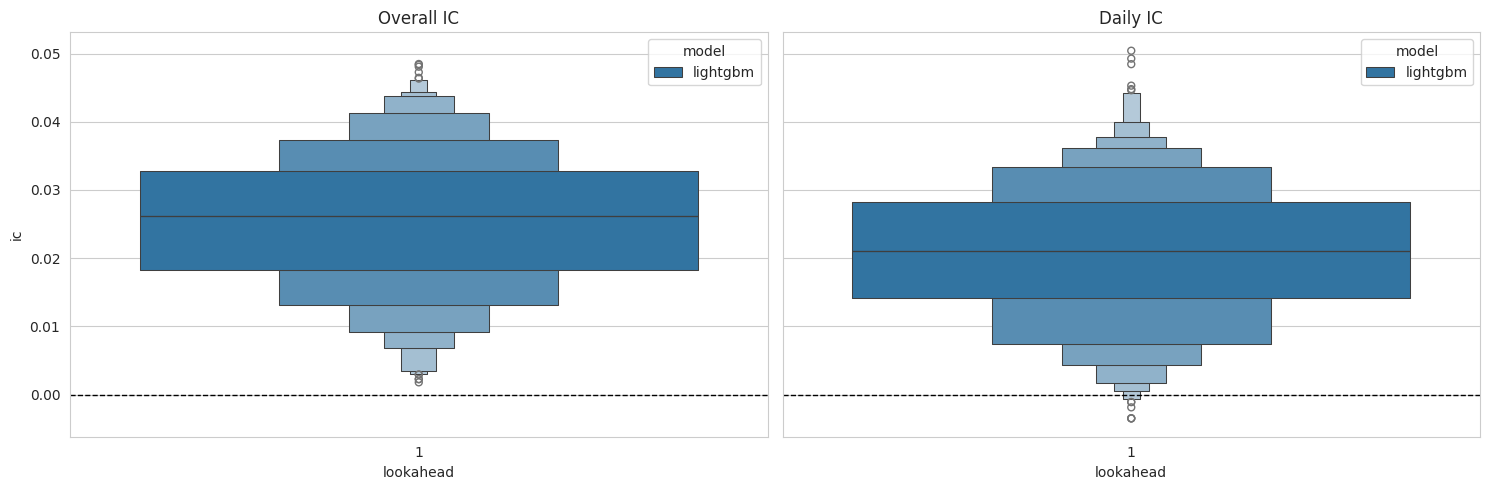

In [126]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=lgb_metrics.assign(model='lightgbm'), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=lgb_daily_ic.assign(model='lightgbm'), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [127]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'ic')).sort_values(["feature_fraction", "ic"], ascending=[True, False])

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
651,1,464,1,0.30,128,0.30,500,25,0.049253
624,1,464,1,0.30,32,0.30,250,10,0.044783
496,1,464,1,0.30,4,0.30,250,50,0.042510
292,1,464,1,0.10,4,0.60,250,200,0.048438
235,1,464,1,0.01,128,0.95,250,25,0.050410
539,1,464,1,0.30,4,0.95,250,200,0.045288
538,1,464,1,0.30,4,0.95,250,150,0.044617
104,1,464,1,0.01,8,0.95,250,10,0.043662
602,1,464,1,0.30,8,0.95,500,100,0.042016
601,1,464,1,0.30,8,0.95,500,75,0.041222


In [128]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'ic')).sort_values(["feature_fraction", "ic"], ascending=[True, False])
# lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
69,1,464,1,0.30,128.0,0.30,500.0,0.049253,25.0,0.045455,10.0,25,0.048464
11,1,464,1,0.30,32.0,0.30,250.0,0.044783,10.0,0.063636,10.0,10,0.047253
469,1,464,1,0.01,8.0,0.30,250.0,0.039065,300.0,0.040909,400.0,300,0.045418
415,1,464,1,0.01,8.0,0.30,250.0,0.039065,300.0,0.040909,400.0,250,0.045307
374,1,464,1,0.01,128.0,0.60,250.0,0.037907,100.0,0.045455,500.0,200,0.048333
320,1,464,1,0.01,128.0,0.60,250.0,0.037907,100.0,0.045455,500.0,150,0.048067
428,1,464,1,0.01,128.0,0.60,250.0,0.037907,100.0,0.045455,500.0,250,0.046325
266,1,464,1,0.01,128.0,0.60,250.0,0.037907,100.0,0.045455,500.0,100,0.045794
346,1,464,1,0.10,4.0,0.60,250.0,0.048438,200.0,0.050000,200.0,200,0.045424
275,1,464,1,0.30,4.0,0.95,250.0,0.045288,200.0,0.072727,75.0,150,0.046444


In [129]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'daily_ic_mean'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
48,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,10,0.039449
102,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,25,0.043222
156,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,50,0.037415
210,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,75,0.037137
264,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,100,0.040963
318,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,150,0.040576
372,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,200,0.041976
426,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,250,0.037037
480,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,300,0.035825
534,1,464,1,0.01,128.0,0.95,250.0,0.05041,25.0,0.063636,25.0,350,0.035297


### Visualization

#### LightGBM

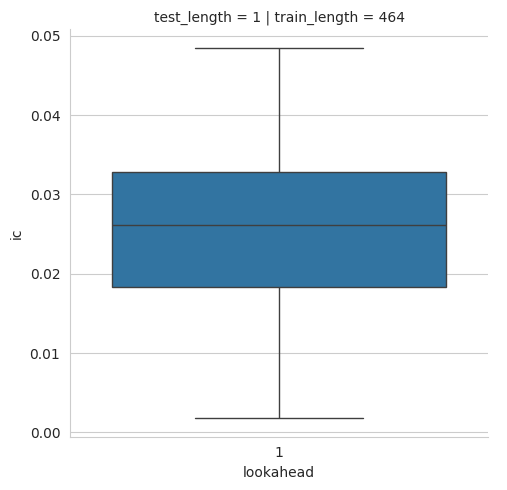

In [130]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

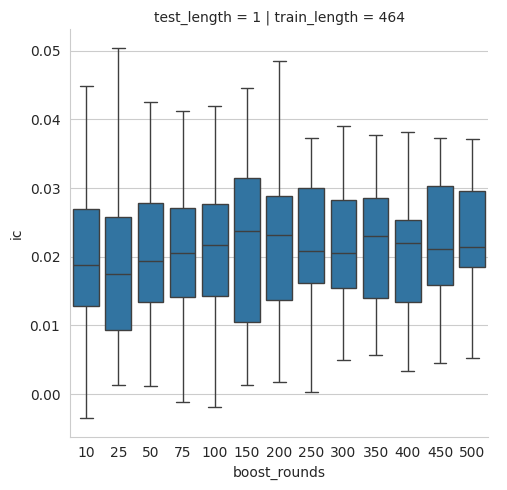

In [131]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [132]:
# lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         702 non-null    int64  
 1   train_length      702 non-null    int64  
 2   test_length       702 non-null    int64  
 3   learning_rate     702 non-null    float64
 4   num_leaves        702 non-null    int64  
 5   feature_fraction  702 non-null    float64
 6   min_data_in_leaf  702 non-null    int64  
 7   boost_rounds      702 non-null    int64  
 8   ic                702 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 49.5 KB


In [133]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [134]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [135]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        464.00
test_length           1.00
learning_rate         0.01
num_leaves          128.00
feature_fraction      0.95
min_data_in_leaf    250.00
boost_rounds         25.00
Name: 235, dtype: float64

In [136]:
# best_params.to_hdf('data.h5', 'best_params')

#### Plot rolling IC

In [137]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

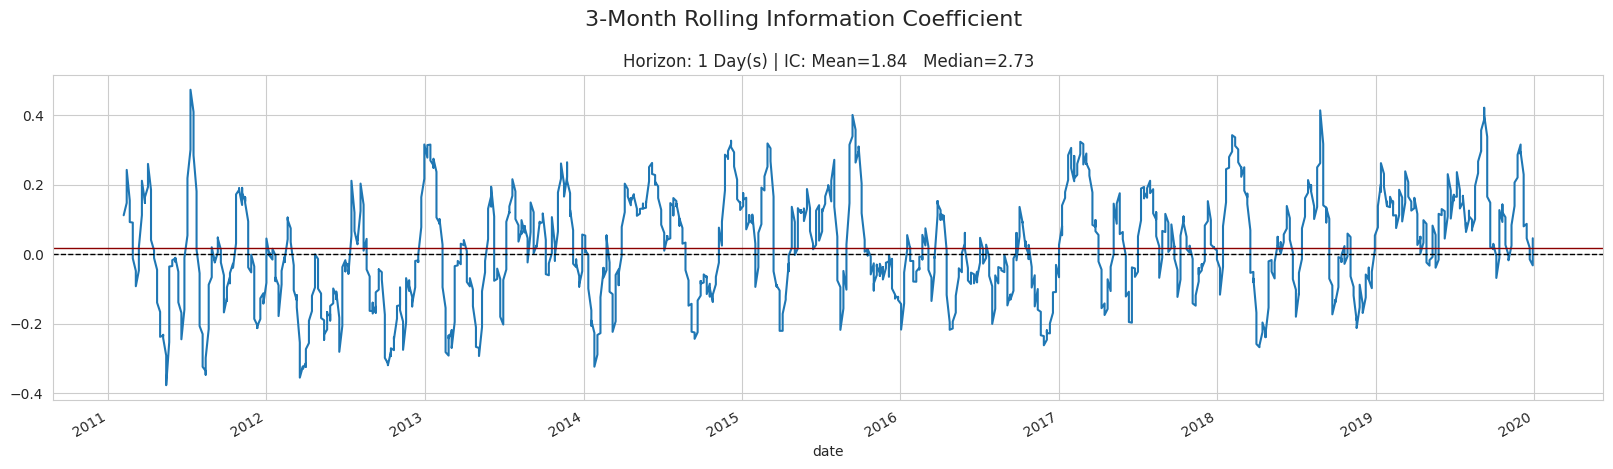

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
# axes = axes.flatten()


for i, t in enumerate([1]): #modificado para meses un lookahead
    params = get_lgb_params(lgb_daily_ic, t=1, best=0)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    #rolling = data.rolling(63).ic.mean().dropna()
    rolling = data.rolling(3*4).ic.mean().dropna()#semanas
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes, title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes.axhline(avg, c='darkred', lw=1)
    axes.axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
# fig.tight_layout()
fig.subplots_adjust(top=0.85);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [139]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()
# best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')

In [140]:

best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5148 entries, ('IYR', Timestamp('2011-01-16 00:00:00')) to ('XLY', Timestamp('2019-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5148 non-null   float64
 1   1       5148 non-null   float64
 2   2       5148 non-null   float64
 3   3       5148 non-null   float64
 4   4       5148 non-null   float64
 5   5       5148 non-null   float64
 6   6       5148 non-null   float64
 7   7       5148 non-null   float64
 8   8       5148 non-null   float64
 9   9       5148 non-null   float64
dtypes: float64(10)
memory usage: 460.2+ KB


#### Get Trade Prices

Using next available prices. !! Esta parte del código no está revisada para una adaptacion mensual, no tomar como buena para conclusiones

In [141]:
#modificado
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    
    with pd.HDFStore(DATA_STORE) as store:
        prices = (store['data_close'])  
    display(prices)
    return (prices.loc[idx[tickers, '2012': '2024'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC')
            .resample('W').last())

In [142]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()#modificado

In [143]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

open        high         low       close     volume  \
ticker date                                                                    
IYR    2000-01-03   19.267872   19.267872   18.455524   18.582453  1185699.0   
       2000-01-04   18.176279   18.201666   17.605097   17.770105   885705.0   
       2000-01-05   17.770105   17.960501   17.440088   17.630484   717181.0   
       2000-01-06   17.681255   18.518990   17.681255   18.404753   415832.0   
       2000-01-07   18.531681   18.734768   18.277822   18.709383   468149.0   
...                       ...         ...         ...         ...        ...   
XLY    2024-12-19  231.759995  232.419998  226.970001  228.330002  6602600.0   
       2024-12-20  226.039993  232.509995  225.500000  228.910004  5457900.0   
       2024-12-23  228.889999  229.399994  226.179993  229.169998  2961200.0   
       2024-12-24  230.139999  234.500000  229.949997  234.470001  1276300.0   
       2024-12-26  233.970001  234.449997  232.570007  233.600006  2054800.0   

                    Adj Close  
ticker date                    
IYR    2000-01-03   11.303078  
       2000-01-04   10.808952  
       2000-01-05   10.724024  
       2000-01-06   11.194983  
       2000-01-07   11.380283  
...                       ...  
XLY    2024-12-19  227.898102  
       2024-12-20  228.477005  
       2024-12-23  229.169998  
       2024-12-24  234.470001  
       2024-12-26  233.600006  

[69146 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 678 entries, 2012-01-08 00:00:00+00:00 to 2024-12-29 00:00:00+00:00
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     678 non-null    float64
 1   VOX     678 non-null    float64
 2   XLB     678 non-null    float64
 3   XLE     678 non-null    float64
 4   XLF     678 non-null    float64
 5   XLI     678 non-null    float64
 6   XLK     678 non-null    float64
 7   XLP     678 non-null    float64
 8   XLU     678 non-null    float64
 9   XLV     678 non-null    float64
 10  XLY     678 non-null    float64
dtypes: float64(11)
memory usage: 63.6 KB


In [144]:
# persist result in case we want to rerun:
# trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
# trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [145]:
trade_prices.tail()

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2024-12-01 00:00:00+00:00,101.849998,155.529999,94.879997,95.500000,51.419998,143.899994,233.899994,83.139999,82.919998,147.320007,223.869995
2024-12-08 00:00:00+00:00,99.820000,161.000000,92.639999,91.779999,50.439999,140.589996,239.940002,82.500000,79.690002,144.419998,234.139999
2024-12-15 00:00:00+00:00,97.750000,162.580002,89.050003,88.970001,49.570000,137.580002,239.360001,82.070000,77.709999,140.880005,236.710007
2024-12-22 00:00:00+00:00,92.209999,156.960007,85.029999,83.309998,48.060001,132.990005,236.250000,79.050003,75.610001,137.600006,228.889999
2024-12-29 00:00:00+00:00,93.070000,158.460007,85.180000,84.669998,48.770000,133.850006,239.759995,79.290001,76.160004,138.830002,233.970001


We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [146]:
best_predictions

0         1         2         3         4         5  \
ticker date                                                                     
IYR    2011-01-16  0.000241  0.033023 -0.148725 -0.272505 -0.041567 -0.336875   
       2011-01-23 -0.027803 -0.230562 -0.242850 -0.463789 -0.169350 -0.353205   
       2011-01-30 -0.016793  0.012984 -0.097043 -0.162913 -0.058292 -0.080217   
       2011-02-06  0.006588 -0.020963 -0.153313  0.048222 -0.239218 -0.042381   
       2011-02-13 -0.006605  0.110679  0.010135  0.132609  0.035080 -0.124470   
...                     ...       ...       ...       ...       ...       ...   
XLY    2019-12-01  0.019724 -0.031434  0.004540 -0.023164  0.114587  0.085026   
       2019-12-08  0.030181  0.218734  0.330524  0.444489  0.211949  0.438157   
       2019-12-15  0.007320 -0.184607 -0.008524 -0.040552 -0.003014  0.216671   
       2019-12-22  0.048683  0.389842  0.241996  0.536717  0.033403  0.578563   
       2019-12-29 -0.006342  0.018909 -0.041607 -0.185759  0.011646 -0.094121   

                          6         7         8         9  
ticker date                                                
IYR    2011-01-16  0.004644 -0.105602 -0.434690 -0.257692  
       2011-01-23  0.001138 -0.281871 -0.381101 -0.243780  
       2011-01-30  0.004837 -0.117100 -0.022818 -0.113105  
       2011-02-06  0.000315 -0.144100 -0.100906 -0.094622  
       2011-02-13  0.001148  0.074620  0.109436 -0.023575  
...                     ...       ...       ...       ...  
XLY    2019-12-01  0.008398  0.008227 -0.018943  0.065611  
       2019-12-08  0.010382  0.303317  0.290513  0.335692  
       2019-12-15  0.007268 -0.074679 -0.200706 -0.073907  
       2019-12-22  0.010386  0.137903  0.642783  0.539721  
       2019-12-29 -0.001729 -0.058834  0.149230  0.242273  

[5148 rows x 10 columns]

In [147]:
factor = best_predictions.iloc[:, :].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [148]:
targets = pd.read_hdf(DATA_STORE, DATA_ITEM).tz_localize('UTC', level='date')['target_1w'].unstack(0).loc['2011':]

In [149]:
factor

date                       ticker
2011-01-16 00:00:00+00:00  IYR      -0.155975
2011-01-23 00:00:00+00:00  IYR      -0.239317
2011-01-30 00:00:00+00:00  IYR      -0.065046
2011-02-06 00:00:00+00:00  IYR      -0.074038
2011-02-13 00:00:00+00:00  IYR       0.031906
                                       ...   
2019-12-01 00:00:00+00:00  XLY       0.023257
2019-12-08 00:00:00+00:00  XLY       0.261394
2019-12-15 00:00:00+00:00  XLY      -0.035473
2019-12-22 00:00:00+00:00  XLY       0.316000
2019-12-29 00:00:00+00:00  XLY       0.003367
Length: 5148, dtype: float64

In [150]:
targets

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2011-01-02 00:00:00+00:00,-1.090646,0.018762,-0.940323,-0.636707,1.008417,0.435365,1.537548,-1.633718,0.083512,1.124897,0.092893
2011-01-09 00:00:00+00:00,-0.064496,-1.752905,-0.002145,1.777319,1.462018,0.456056,0.283640,-0.201543,-0.629173,-0.762024,-0.566747
2011-01-16 00:00:00+00:00,0.548952,-0.872672,-2.129875,-0.008764,-0.636578,0.598120,-0.769578,1.061671,1.155546,0.645750,0.407427
2011-01-23 00:00:00+00:00,1.481012,0.378399,0.894826,1.321433,-0.746872,0.076021,0.550094,-1.092211,-0.490414,-1.147329,-1.224958
2011-01-30 00:00:00+00:00,-1.114026,-0.182536,1.681575,1.350585,-0.197474,0.134774,0.651464,-1.044198,-1.524474,-0.149940,0.394249
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,-0.509433,1.415623,-0.654954,-1.182250,-0.282094,-0.453767,1.235626,-0.026213,-0.928681,-0.373167,1.759309
2024-12-08 00:00:00+00:00,-0.520420,1.204178,-1.171160,-0.434991,-0.222191,-0.630527,0.533441,0.792750,-0.901721,-0.672480,2.023119
2024-12-15 00:00:00+00:00,-1.603796,-0.067481,-0.735287,-1.842797,0.654193,0.275880,1.197516,0.322202,1.013862,0.625464,0.160246


In [151]:
targets["factor"] = factor

In [152]:
factor

date                       ticker
2011-01-16 00:00:00+00:00  IYR      -0.155975
2011-01-23 00:00:00+00:00  IYR      -0.239317
2011-01-30 00:00:00+00:00  IYR      -0.065046
2011-02-06 00:00:00+00:00  IYR      -0.074038
2011-02-13 00:00:00+00:00  IYR       0.031906
                                       ...   
2019-12-01 00:00:00+00:00  XLY       0.023257
2019-12-08 00:00:00+00:00  XLY       0.261394
2019-12-15 00:00:00+00:00  XLY      -0.035473
2019-12-22 00:00:00+00:00  XLY       0.316000
2019-12-29 00:00:00+00:00  XLY       0.003367
Length: 5148, dtype: float64

In [153]:
targets

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,factor
date,,,,,,,,,,,,
2011-01-02 00:00:00+00:00,-1.090646,0.018762,-0.940323,-0.636707,1.008417,0.435365,1.537548,-1.633718,0.083512,1.124897,0.092893,NaN
2011-01-09 00:00:00+00:00,-0.064496,-1.752905,-0.002145,1.777319,1.462018,0.456056,0.283640,-0.201543,-0.629173,-0.762024,-0.566747,NaN
2011-01-16 00:00:00+00:00,0.548952,-0.872672,-2.129875,-0.008764,-0.636578,0.598120,-0.769578,1.061671,1.155546,0.645750,0.407427,NaN
2011-01-23 00:00:00+00:00,1.481012,0.378399,0.894826,1.321433,-0.746872,0.076021,0.550094,-1.092211,-0.490414,-1.147329,-1.224958,NaN
2011-01-30 00:00:00+00:00,-1.114026,-0.182536,1.681575,1.350585,-0.197474,0.134774,0.651464,-1.044198,-1.524474,-0.149940,0.394249,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,-0.509433,1.415623,-0.654954,-1.182250,-0.282094,-0.453767,1.235626,-0.026213,-0.928681,-0.373167,1.759309,NaN
2024-12-08 00:00:00+00:00,-0.520420,1.204178,-1.171160,-0.434991,-0.222191,-0.630527,0.533441,0.792750,-0.901721,-0.672480,2.023119,NaN
2024-12-15 00:00:00+00:00,-1.603796,-0.067481,-0.735287,-1.842797,0.654193,0.275880,1.197516,0.322202,1.013862,0.625464,0.160246,NaN


In [154]:
factor.tail()

date                       ticker
2019-12-01 00:00:00+00:00  XLY       0.023257
2019-12-08 00:00:00+00:00  XLY       0.261394
2019-12-15 00:00:00+00:00  XLY      -0.035473
2019-12-22 00:00:00+00:00  XLY       0.316000
2019-12-29 00:00:00+00:00  XLY       0.003367
dtype: float64

In [155]:
factor = factor.tz_convert('UTC', level='date')

In [156]:
targets

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,factor
date,,,,,,,,,,,,
2011-01-02 00:00:00+00:00,-1.090646,0.018762,-0.940323,-0.636707,1.008417,0.435365,1.537548,-1.633718,0.083512,1.124897,0.092893,NaN
2011-01-09 00:00:00+00:00,-0.064496,-1.752905,-0.002145,1.777319,1.462018,0.456056,0.283640,-0.201543,-0.629173,-0.762024,-0.566747,NaN
2011-01-16 00:00:00+00:00,0.548952,-0.872672,-2.129875,-0.008764,-0.636578,0.598120,-0.769578,1.061671,1.155546,0.645750,0.407427,NaN
2011-01-23 00:00:00+00:00,1.481012,0.378399,0.894826,1.321433,-0.746872,0.076021,0.550094,-1.092211,-0.490414,-1.147329,-1.224958,NaN
2011-01-30 00:00:00+00:00,-1.114026,-0.182536,1.681575,1.350585,-0.197474,0.134774,0.651464,-1.044198,-1.524474,-0.149940,0.394249,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,-0.509433,1.415623,-0.654954,-1.182250,-0.282094,-0.453767,1.235626,-0.026213,-0.928681,-0.373167,1.759309,NaN
2024-12-08 00:00:00+00:00,-0.520420,1.204178,-1.171160,-0.434991,-0.222191,-0.630527,0.533441,0.792750,-0.901721,-0.672480,2.023119,NaN
2024-12-15 00:00:00+00:00,-1.603796,-0.067481,-0.735287,-1.842797,0.654193,0.275880,1.197516,0.322202,1.013862,0.625464,0.160246,NaN


In [157]:
trade_prices

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2012-01-08 00:00:00+00:00,56.930000,61.500000,34.820000,70.589996,10.926076,34.689999,26.059999,32.240002,35.130001,35.200001,40.160000
2012-01-15 00:00:00+00:00,58.220001,63.160000,36.540001,70.220001,11.234768,35.970001,26.260000,32.410000,35.090000,35.709999,40.610001
2012-01-22 00:00:00+00:00,59.119999,63.180000,36.639999,71.629997,11.494720,36.099998,26.840000,32.310001,34.560001,35.860001,41.169998
2012-01-29 00:00:00+00:00,60.259998,61.320000,36.619999,70.660004,11.348497,36.130001,26.670000,32.080002,34.599998,35.599998,41.090000
2012-02-05 00:00:00+00:00,61.880001,63.310001,37.599998,72.360001,11.900894,37.000000,27.639999,32.410000,34.779999,36.060001,41.990002
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01 00:00:00+00:00,101.849998,155.529999,94.879997,95.500000,51.419998,143.899994,233.899994,83.139999,82.919998,147.320007,223.869995
2024-12-08 00:00:00+00:00,99.820000,161.000000,92.639999,91.779999,50.439999,140.589996,239.940002,82.500000,79.690002,144.419998,234.139999
2024-12-15 00:00:00+00:00,97.750000,162.580002,89.050003,88.970001,49.570000,137.580002,239.360001,82.070000,77.709999,140.880005,236.710007


#### Create AlphaLens Inputs

In [167]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   bins=5,
                                                   quantiles=None,
                                                   #periods=(1, 2))#modificado
                                                   periods=(1,),max_loss=0.9)#modificado

Dropped 10.9% entries from factor data: 10.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!


In [168]:
factor_data

,,1D,factor,factor_quantile
date,asset,,,
2012-01-08 00:00:00+00:00,IYR,0.022659,-0.093208,1
2012-01-15 00:00:00+00:00,IYR,0.015459,-0.006138,4
2012-01-22 00:00:00+00:00,IYR,0.019283,0.140137,5
2012-01-29 00:00:00+00:00,IYR,0.026884,0.108384,4
2012-02-05 00:00:00+00:00,IYR,-0.009696,0.022668,3
...,...,...,...,...
2019-12-01 00:00:00+00:00,XLY,-0.007263,0.023257,4
2019-12-08 00:00:00+00:00,XLY,0.017756,0.261394,5
2019-12-15 00:00:00+00:00,XLY,0.008158,-0.035473,2


#### Compute Alphalens metrics

In [169]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [170]:
factor_returns = perf.factor_returns(factor_data)

In [171]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [172]:
import numpy as np

# Reemplazar infinitos con la media de cada columna numérica
numeric_cols = factor_data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mask = np.isinf(factor_data[col])
    factor_data.loc[mask, col] = factor_data[col].replace([np.inf, -np.inf], np.nan).mean()

print("Number of NaN values in factor_data:")
print(factor_data.isna().sum())
print("\nTotal NaN values:", factor_data.isna().sum().sum())
print("\nNumber of infinite values:", np.isinf(factor_data.select_dtypes(include=np.number)).sum().sum())
print("\nShape of factor_data:", factor_data.shape)
print("\nSample of factor_data:")
factor_data

Number of NaN values in factor_data:
1D                 0
factor             0
factor_quantile    0
dtype: int64

Total NaN values: 0

Number of infinite values: 0

Shape of factor_data: (4587, 3)

Sample of factor_data:


,,1D,factor,factor_quantile
date,asset,,,
2012-01-08 00:00:00+00:00,IYR,0.022659,-0.093208,1.0
2012-01-15 00:00:00+00:00,IYR,0.015459,-0.006138,4.0
2012-01-22 00:00:00+00:00,IYR,0.019283,0.140137,5.0
2012-01-29 00:00:00+00:00,IYR,0.026884,0.108384,4.0
2012-02-05 00:00:00+00:00,IYR,-0.009696,0.022668,3.0
...,...,...,...,...
2019-12-01 00:00:00+00:00,XLY,-0.007263,0.023257,4.0
2019-12-08 00:00:00+00:00,XLY,0.017756,0.261394,5.0
2019-12-15 00:00:00+00:00,XLY,0.008158,-0.035473,2.0


In [173]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [174]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D
Mean Period Wise Spread (bps),21.841768
Ann. alpha,0.204727
beta,0.042294


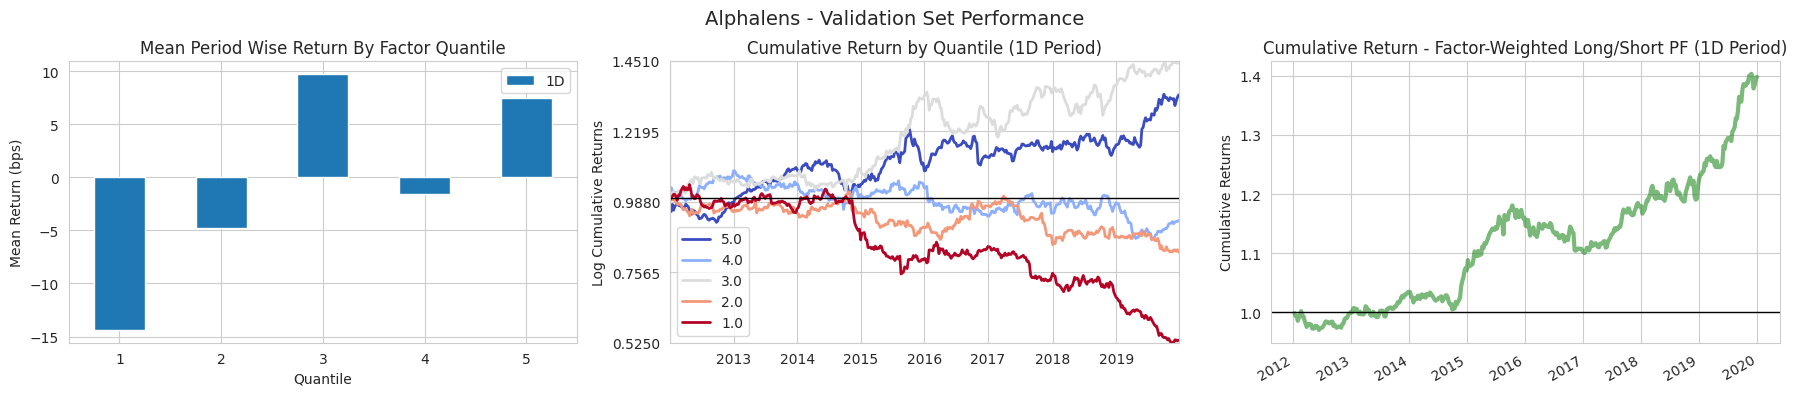

In [175]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.482642,0.075243,-0.134078,0.084675,904,19.707870
2.0,-0.261874,0.120511,-0.054506,0.061527,839,18.290822
3.0,-0.192269,0.191750,0.008721,0.054723,1002,21.844343
4.0,-0.171400,0.274596,0.060189,0.058189,911,19.860475
5.0,-0.071855,0.436035,0.146991,0.071396,931,20.296490


Returns Analysis


,1D
Ann. alpha,0.205
beta,0.042
Mean Period Wise Return Top Quantile (bps),7.463
Mean Period Wise Return Bottom Quantile (bps),-14.379
Mean Period Wise Spread (bps),21.842


Information Analysis


,1D
IC Mean,0.052
IC Std.,0.337
Risk-Adjusted IC,0.155
t-stat(IC),3.171
p-value(IC),0.002
IC Skew,0.090
IC Kurtosis,-0.711


Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.697
Quantile 2 Mean Turnover,0.784
Quantile 3 Mean Turnover,0.763
Quantile 4 Mean Turnover,0.750
Quantile 5 Mean Turnover,0.735


,1D
Mean Factor Rank Autocorrelation,0.145


<Figure size 640x480 with 0 Axes>

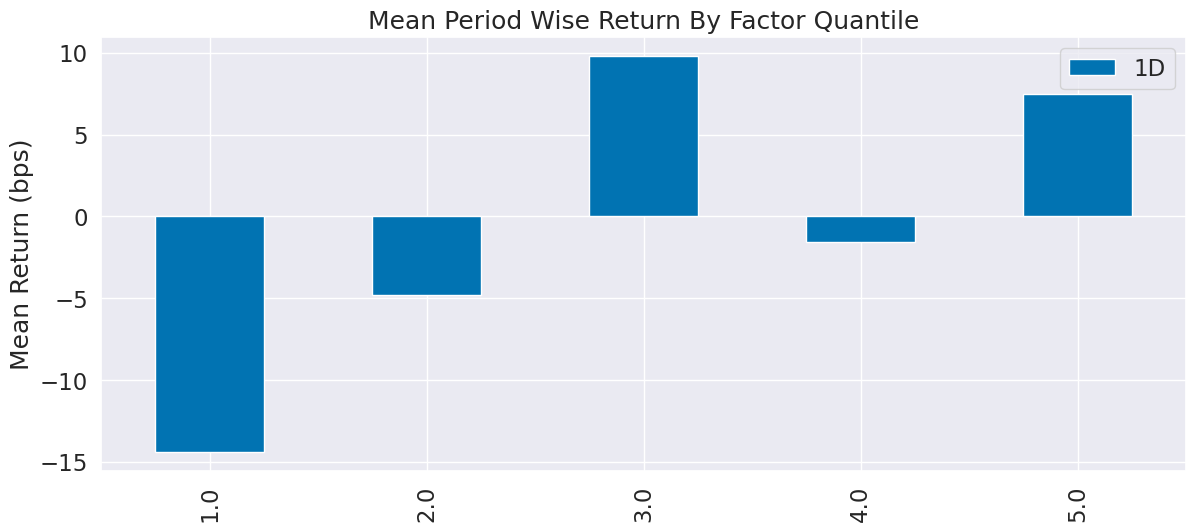

In [48]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.482642,0.075243,-0.134078,0.084675,904,19.707870
2.0,-0.261874,0.120511,-0.054506,0.061527,839,18.290822
3.0,-0.192269,0.191750,0.008721,0.054723,1002,21.844343
4.0,-0.171400,0.274596,0.060189,0.058189,911,19.860475
5.0,-0.071855,0.436035,0.146991,0.071396,931,20.296490


Returns Analysis


,1D
Ann. alpha,0.205
beta,0.042
Mean Period Wise Return Top Quantile (bps),7.463
Mean Period Wise Return Bottom Quantile (bps),-14.379
Mean Period Wise Spread (bps),21.842


<Figure size 640x480 with 0 Axes>

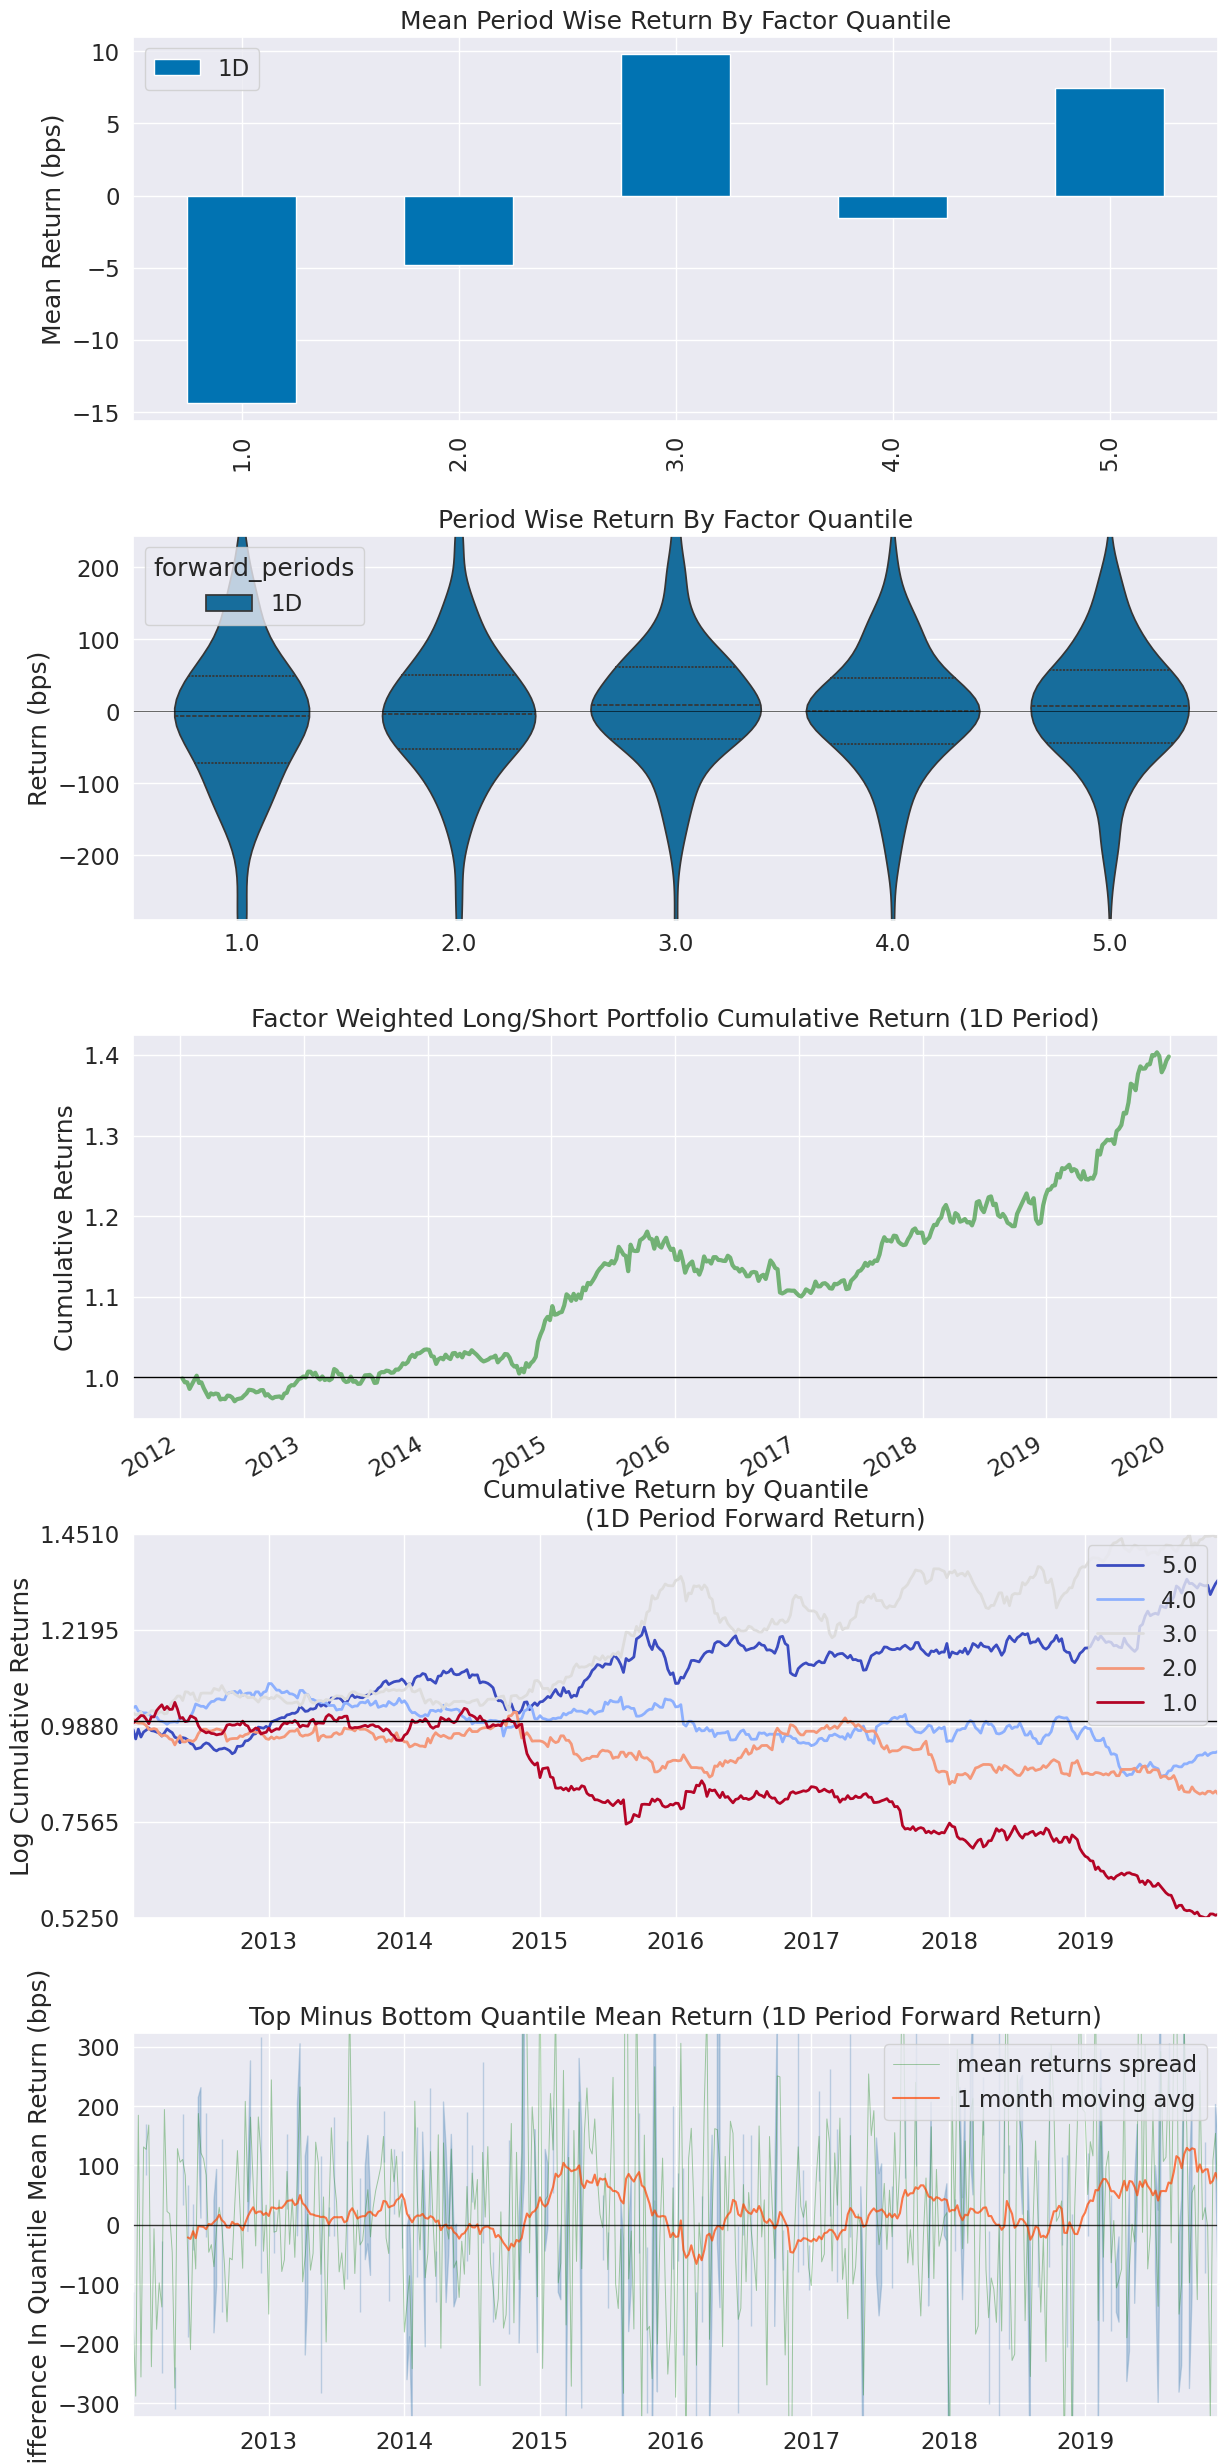

Information Analysis


,1D
IC Mean,0.052
IC Std.,0.337
Risk-Adjusted IC,0.155
t-stat(IC),3.171
p-value(IC),0.002
IC Skew,0.090
IC Kurtosis,-0.711


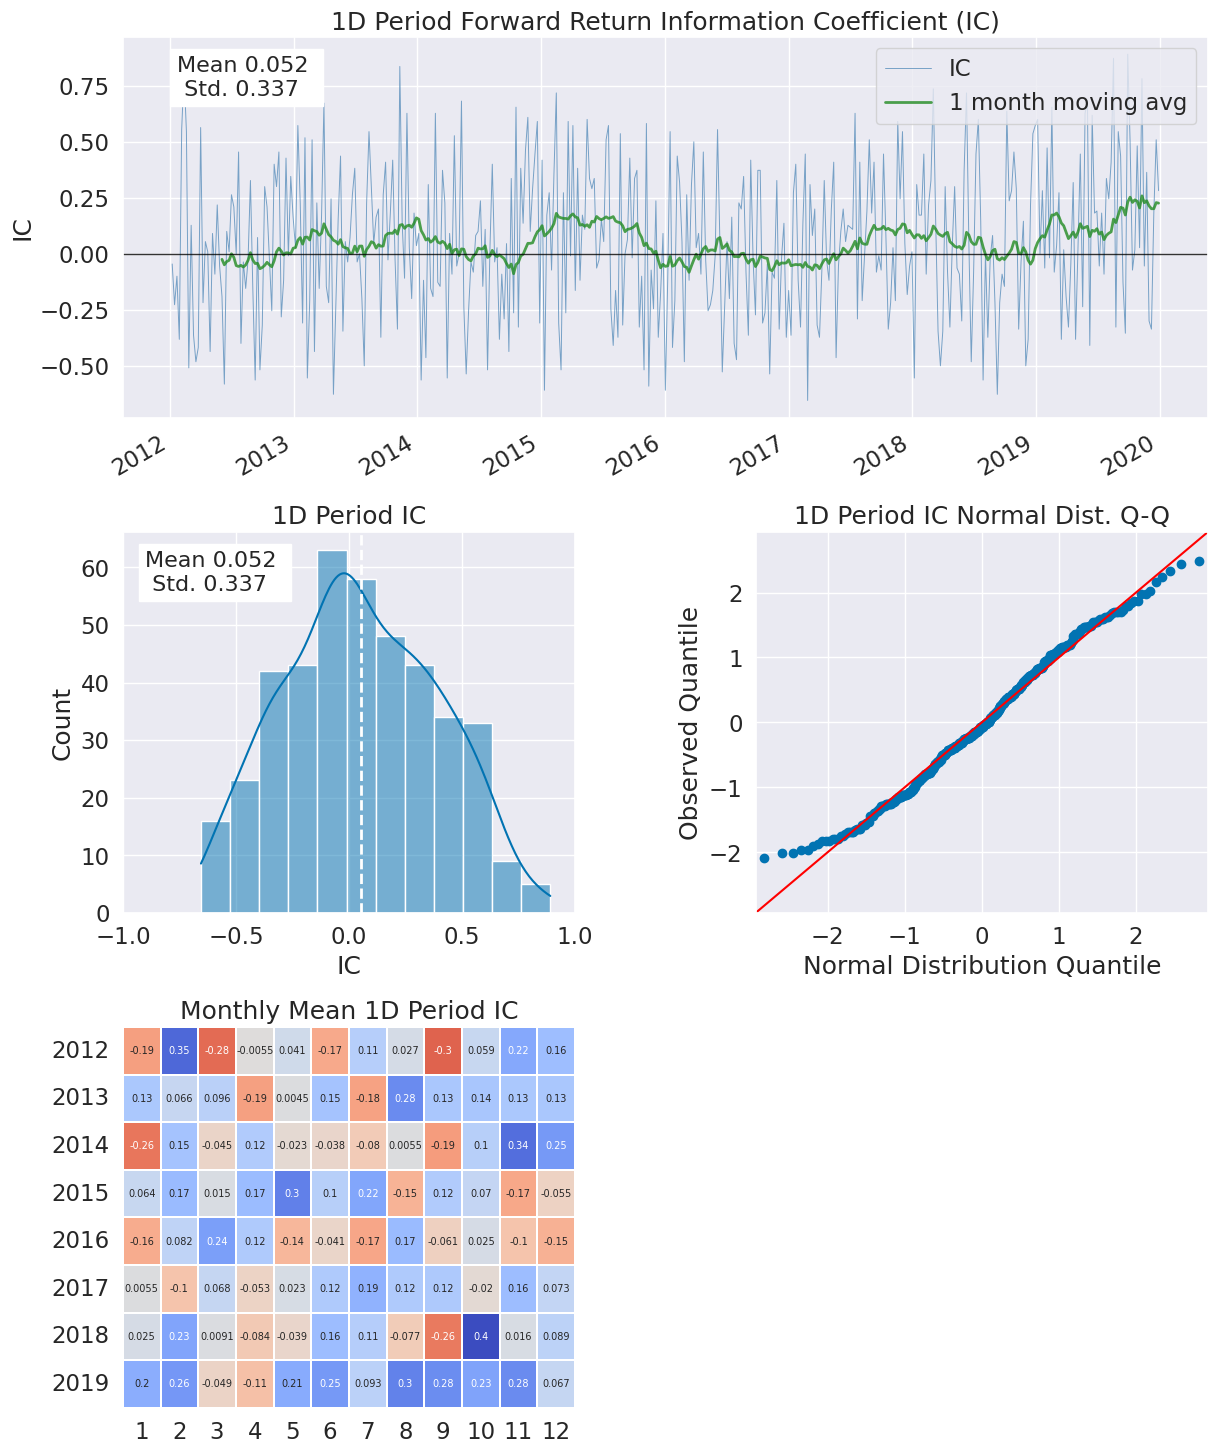

Turnover Analysis


,1D
Quantile 1.0 Mean Turnover,0.697
Quantile 2.0 Mean Turnover,0.784
Quantile 3.0 Mean Turnover,0.763
Quantile 4.0 Mean Turnover,0.750
Quantile 5.0 Mean Turnover,0.735


,1D
Mean Factor Rank Autocorrelation,0.145


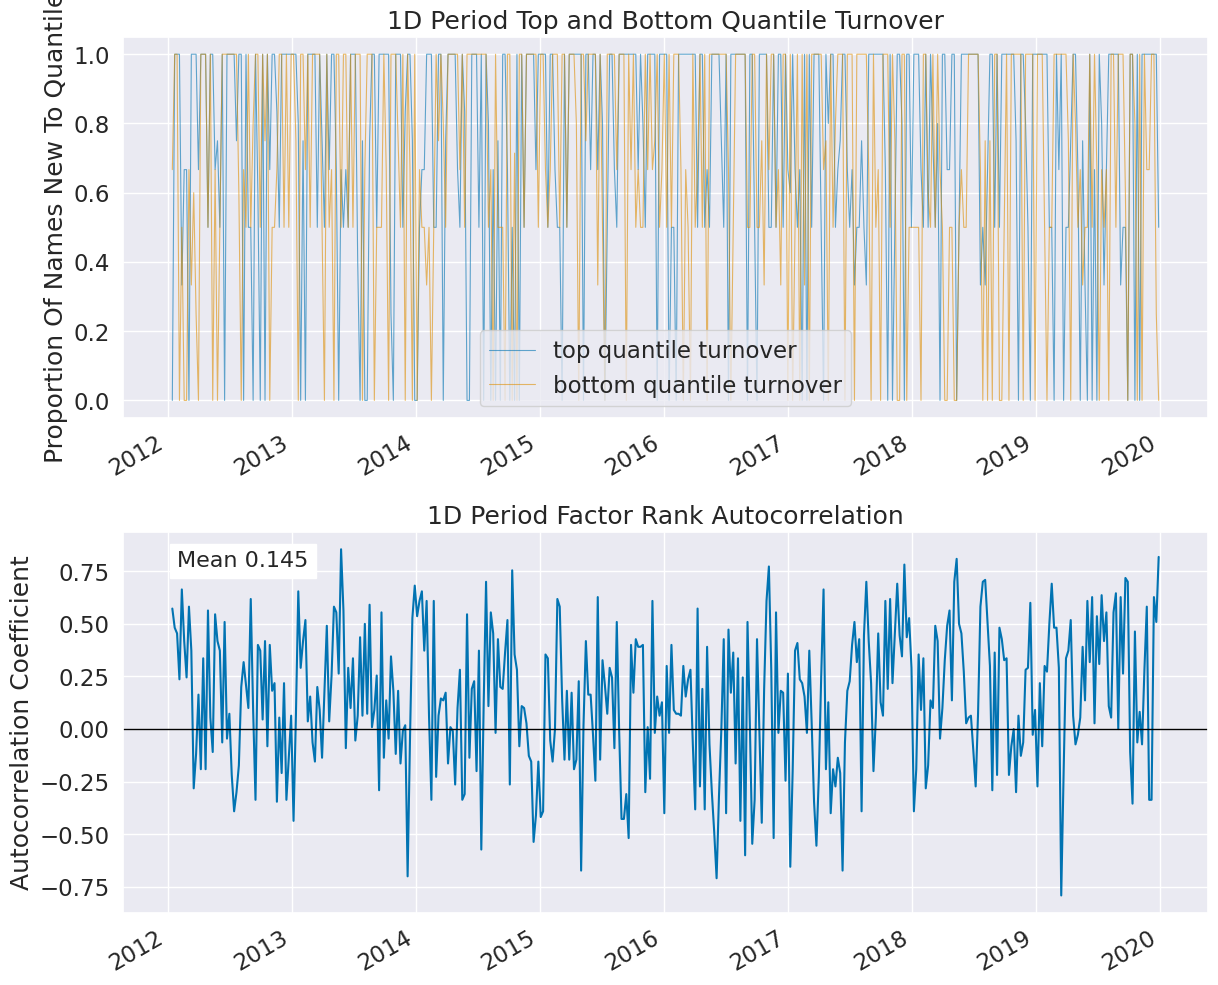

In [49]:
create_full_tear_sheet(factor_data)